In [1]:
%matplotlib inline
import numpy as np
from paper_plot import *
from myfunctions import MJD_to_MET, MET_to_MJD
import pyfits as fits
from xml.etree import ElementTree as ET
import os
MeV_to_erg = 1.60218e-6
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['white', 'red', '#800000'])

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


51910.0007429


In [2]:
MJD_to_MET(56961)
MET_to_MJD(444957874.28219837)

array(57059.976139655075)

In [3]:
@np.vectorize
def powerlaw(E, prefactor, index, E0):
    return prefactor*(E/E0)**index

@np.vectorize
def log_parabola(E, norm, alpha, beta, Eb):
    return norm*(E/Eb)**(-alpha+beta*np.log(E/Eb))

In [4]:
def make_edges(data_f):
    header = data_f[0].header
    xmin = header['CRVAL1']-header['CRPIX1']*abs(header['CDELT1'])
    xmax = header['CRVAL1']+header['CRPIX1']*abs(header['CDELT1'])
    ymin = header['CRVAL2']-header['CRPIX2']*abs(header['CDELT2'])
    ymax = header['CRVAL2']+header['CRPIX2']*abs(header['CDELT2']) 
    xbins = header['NAXIS1']
    ybins = header['NAXIS2']
    return xmin, xmax, ymin, ymax, xbins, ybins

def in_window(xmin,xmax,ymin,ymax, ra ,dec):
    if (ra>xmin) and (ra<xmax) and (dec>ymin) and (dec<ymax):
        return True
    else:
        return False
    

def most_significant_src(res_file, xml_file, window): 
    valid_position = lambda ra, dec : in_window(window[0], window[1],
                                                window[2], window[3], ra, dec)
    
    tree = ET.parse(xml_file)
    root = tree.getroot()
    pos_dict = dict()
    for child in root.getchildren():
        this_src = child.attrib['name']
        spat = child.find('spatialModel')
        coords = np.zeros(2)
        for key in spat:
            if key.attrib['name'] == 'RA':
                coords[0] = float(key.attrib['scale'])*float(key.attrib['value'])
            if key.attrib['name'] == 'DEC':
                coords[1] = float(key.attrib['scale'])*float(key.attrib['value'])
        pos_dict[this_src]=coords
        
    with open(res_file) as results:
        res_dict = eval(results.read())
    TS_vals = []
    src_name = []
    for src in res_dict:
        #print '{} {}, {}'.format(src, pos_dict[src][0], pos_dict[src][1])
        if (src=='iso_P8R2_SOURCE_V6_v06') or (src=='gll_iem_v06'):
            print 'ok'
            continue
        if valid_position(pos_dict[src][0], pos_dict[src][1]):
            if 'TS value' in res_dict[src].keys():
                TS_vals.append(float(res_dict[src]['TS value']))
            else:
                TS_vals.append(0)
            src_name.append(src)
    
    inds = np.argsort(TS_vals)[::-1]
    n = 5
    sig_TS = np.array(TS_vals)[inds[:n]]
    sig_src = np.array(src_name)[inds[:n]]
    
    sig_src_dict = dict()
    for i, src in enumerate(sig_src):
        sig_src_dict[src]={'pos' : pos_dict[src],
                           'TS' : sig_TS[i]}
        
    return sig_src_dict

In [6]:
time = '56949_57059' #'56949_57059' #57908_58018
emin = '2GeV'
mfile = 'model.fits' #'diffuse.fits'
folder = '{}/{}'.format(time, emin)
TS_data = fits.open('./TXS/{}/{}'.format(folder, mfile))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


ok
ok
{'2WHSP': {'pos': array([ 77.139125,   5.519194]), 'TS': -7.2831999999999997e-05}, '3FGL J0505.3+0459': {'pos': array([ 76.3432,   4.9979]), 'TS': 248.30000000000001}, '3FGL J0509.4+0541': {'pos': array([ 77.3639,   5.699 ]), 'TS': 93.319699999999997}}


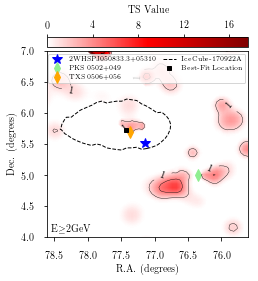

In [11]:
plt_lim = [75.8, 79, 4.5, 7.]
fig = plt.figure(figsize=figsize(0.4, 1.))
plt.clf()
ax=fig.add_axes((.0, .0,1.,.93))
xmin, xmax, ymin, ymax, xbins, ybins = make_edges(TS_data)
X=np.linspace(xmin, xmax, xbins)[::-1]
Y=np.linspace(ymin, ymax, ybins)
Z=TS_data[0].data
Z[np.where(Z<0)]=0.001
plt_src = most_significant_src('./TXS/{}/results.dat'.format(folder),
                               './TXS/{}/model.xml'.format(folder), 
                               plt_lim)
print plt_src
alias= {'3FGL J0505.3+0459': ['PKS 0502+049','d',8], 
        '3FGL J0509.4+0541': ['TXS 0506+056', 'd',8],
        '2WHSP': ['2WHSPJ050833.3+05310', '*',11],
       }
plt_src['2WHSP'] = {'pos':[77.139125, 5.519194]}
for i, src in enumerate(plt_src):
    ax.plot(plt_src[src]['pos'][0], plt_src[src]['pos'][1], marker=alias[src][1], ms=alias[src][2],
             color= color[i], label=alias[src][0], lw=0, zorder=1)
# cmap = plt.cm.Reds
# cmap.set_under('white')
cbar = ax.contourf(X,Y,Z, levels=np.linspace(np.min(Z), np.max(Z), 500),
                    cmap=cmap, vmin=0) 
levels=np.linspace(np.min(Z), np.max(Z), 30)[2::5]
CS = ax.contour(X,Y,Z, levels=levels,
                colors='black', linewidths=(0.4,))
plt.clabel(CS, levels[::2], fontsize=11, fmt='%1.0f', inline =1,
           inline_spacing =1, colors='black', zorder=5)
contour_path = './contour_90.npy'
if os.path.exists(contour_path):
    contour = np.load(contour_path)
    ax.plot(np.concatenate(contour[:,0:1]),
            np.concatenate(contour[:,1:2]),
            zorder=2, color='k',
            linestyle='--', label='IceCube-170922A', lw=1.)
    ax.plot(77.43, 5.72, label='Best-Fit Location', linestyle='',
            marker='s', color='k', zorder=2, ms=4)
ax.set_xlabel(r'R.A. (degrees)')
ax.set_ylabel(r'Dec. (degrees)')
ax.set_xlim(75.6, 78.6)
ax.set_ylim(4.0, 7.0)
plt.gca().invert_xaxis()
plt.legend(loc='best', ncol=2, columnspacing=1., fontsize=6.5)
# colorbar
ax2=fig.add_axes((.0, .95,1.,.05))
plt_cbar = fig.colorbar(cbar, orientation="horizontal", cax=ax2, ticks=np.arange(0, np.max(Z), 4) )
plt_cbar.set_label('TS Value', labelpad=8)
plt_cbar.ax.xaxis.set_ticks_position('top')
plt_cbar.ax.xaxis.set_label_position('top')
plt.text(0.02, 0.02, 'E$\geq${}'.format(emin), horizontalalignment='left', verticalalignment='bottom',
         transform=ax.transAxes, fontsize=10)
ax2.tick_params(axis='x', which='major', pad=3)


plt.savefig('TS_{}_{}_{}.png'.format(mfile[:-5],time, emin), dpi=400, bbox_inches='tight')
plt.show()

# ROI

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  import sys


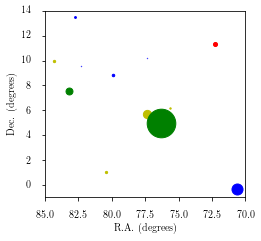

In [46]:
tree = ET.parse('./TXS/56949_57059/100MeV/model.xml')
res_file = './TXS/56949_57059/100MeV/results.dat'
with open(res_file) as results:
    res_dict = eval(results.read())
root = tree.getroot()
pos_dict = dict()
for child in root.getchildren():
    this_src = child.attrib['name']
    spat = child.find('spatialModel')
    coords = np.zeros(3)
    for key in spat:
        if key.attrib['name'] == 'RA':
            coords[0] = float(key.attrib['scale'])*float(key.attrib['value'])
        if key.attrib['name'] == 'DEC':
            coords[1] = float(key.attrib['scale'])*float(key.attrib['value'])
        if 'TS value' in res_dict[this_src].keys():
            coords[2] = float(res_dict[this_src]['TS value'])
    pos_dict[this_src]=coords
    
fig = plt.figure(figsize=figsize(0.4, 1.))
plt.clf()
ax=fig.add_axes((.0, .0,1.,.93))
for src in pos_dict:
    plt.scatter(pos_dict[src][0], pos_dict[src][1], s = 0.5*pos_dict[src][2])
ax.set_xlim(70, 85)
ax.set_ylim(-1, 14.)
plt.gca().invert_xaxis()
ax.set_xlabel(r'R.A. (degrees)')
ax.set_ylabel(r'Dec. (degrees)')
plt.savefig('gamma_ROI.pdf', bbox_inches='tight')